In [2]:
import numpy as np
from sklearn.base import BaseEstimator
from scipy.stats import bernoulli
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as colors

Consider a `SporadicClassifier` that returns a random label in {`True`, `False`} for any test input that’s fed to it. This classifier does not require any training! Hope, that was already obvious to you. Implement this `SporadicClassifier` as a Python class by extending the `BaseEstimator` class of sklearn, so that you have mandatory methods such as `fit(X, y)` and `predict(X)` are implemented. As your guess, the `fit()` method would be a dummy ‘pass’, but the `predict()` method would return `True` or `False` randomly.

In [3]:
class SporadicClassifier(BaseEstimator):
    def __init__(self, p=0.5, method='uniform_random'):
        # when p = 1.0, bernoulli and uniform_random are misbehaving for some unknown reason!
        if p > 0.999:
            p = 0.999
        self.p = 0.5 if p < 0.0 or p > 1.0 else p
        self.method = method if method in ["bernoulli", "gaussian"] else "uniform_random"
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        # we center the normal distribution at 0.5 instead of 0.0
        if self.method == "gaussian":
            return (0.5 + np.random.randn(len(X))) < self.p
        elif self.method == "bernoulli":
            return np.bool_(bernoulli.rvs(self.p, size=len(X)))
        else:
            return np.random.rand(len(X)) < self.p

__it does not matter what the dataset is, as the classifier is not depending on the inputs__

In [4]:
# let's create a dataset of size 100 instances.
X = np.random.rand(100)

__let's compute the label distribution for different configuration of the classifier__

In [5]:
cla = SporadicClassifier(p=0.3, method='gaussian')
y = cla.predict(X)
c = Counter(y) 
{i[0]: i[1] / len(y) for i in c.items()}

{False: 0.56, True: 0.44}

__create reusable functions__

In [6]:
def compute_prior(y):
    # initialize the counter object on the 'y' labels
    c = Counter(y)
    # convert the labels into class proportions
    props = {i[0]:i[1]/len(y) for i in c.items()}
    if True not in props:
        props[True] = 0.0
    if False not in props:
        props[False] = 0.0
    return props

__extract the probability of True predictions for the dataset using different random generators__

In [7]:
p_vals = np.arange(0., 1., 0.1)
b_vals = []
g_vals = []
u_vals = []
for p in p_vals:
    # spawn the sporadic classifier with bernouli random sample generator
    cla = SporadicClassifier(p=p, method='bernoulli')
    # predict the labels for the input
    y = cla.predict(X)
    # compute priors
    props = compute_prior(y)
    # pick the probabilty of True class
    b_vals.append(props[True])
    
    # spawn the sporadic classifier with gaussian random sample generator
    y = SporadicClassifier(p=p, method='gaussian').predict(X)
    g_vals.append(compute_prior(y)[True])
    
    # spawn the sporadic classifier with uniform random sample generator
    y = SporadicClassifier(p=p, method='uniform_random').predict(X)
    u_vals.append(compute_prior(y)[True])

__plot the trends side on the same plot for comparison__

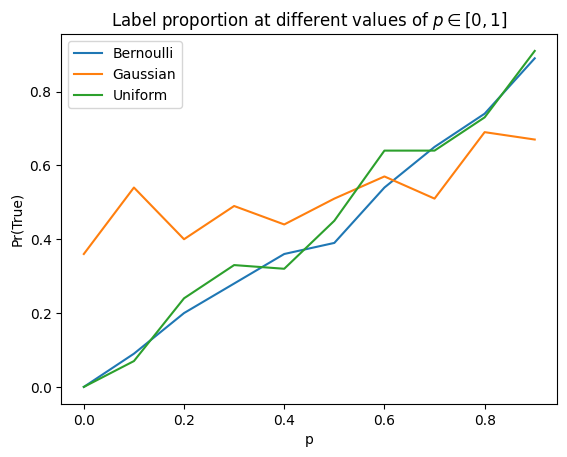

In [10]:

plt.plot(p_vals, b_vals)
plt.plot(p_vals, g_vals)
plt.plot(p_vals, u_vals)
plt.xlabel('p')
plt.ylabel('Pr(True)')
plt.title('Label proportion at different values of $p\\in[0,1]$')
plt.legend(['Bernoulli','Gaussian','Uniform'], loc='upper left')
plt.show()

___if the number of samples is increased, the plots tend to understandably become a straight line___

__let's try to visualize the decision boundary of the SporadicClassifier. Setup a helper function to create the visualization.__

In [11]:
def visualize_decision_boundary(X, y, model, plotter=None, title=""):
    # create the x1 and x2 axis as a linear space spawning from the minimum to maximum feature values.
    x1 = X[X.columns[0]]
    x2 = X[X.columns[1]]
    grid_x1 = np.linspace(x1.min(), x1.max(), 100)
    grid_x2 = np.linspace(x2.min(), x2.max(), 100)
    x1v, x2v = np.meshgrid(grid_x1, grid_x2)
    # create the test dataframe
    test_data = pd.DataFrame(data=np.column_stack((x1v.flatten(), x2v.flatten())), columns=X.columns)
    test_yhat = model.predict(test_data)
    # plot the data
    color_map = colors.ListedColormap(['red','green'])

    plt_ = plotter if plotter != None else plt
    plt_.scatter(x1v, x2v, marker='.', s=2, c=test_yhat, cmap=color_map)
    plt_.scatter(x1, x2, marker='.', c=y, cmap=color_map)
    if title != "":
        if plotter != None:
            plt_.set_title(title)
        else:
            plt_.title(title)
    return plt_

__load the iris dataset__

In [13]:
iris = load_iris()
df = pd.DataFrame(data = iris.data, columns=iris.feature_names)
df["label_"] = iris.target

def stringify(y):
    if y == 0:
        return "setosa"
    elif y == 1:
        return "versicolor"
    else:
        return "virginica"
        
df["label"] = df.label_.apply(lambda x: stringify(x))
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label_,label
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


__convert the 3-class dataset into a binary class dataset__

original class population:
 label
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

binary class population:
 blabel
1    100
0     50
Name: count, dtype: int64


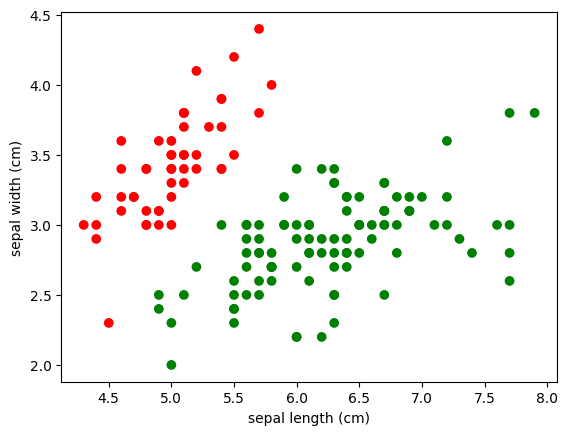

In [15]:

# display the population of each class
print("original class population:\n", df.label.value_counts())
# combine versicolor and virginica to be one class
df['blabel'] = df.label_.apply(lambda x: x if x == 0 else 1)
# display the population of the binary classes
print("\nbinary class population:\n", df.blabel.value_counts())
# we will consider only 2 input features for easier visualization
df_x = df[['sepal length (cm)', 'sepal width (cm)']] #, 'petal length (cm)', 'petal width (cm)']])
xx = np.array(df_x) 
yy = np.array(df.blabel)

plt.scatter(xx[:,0], xx[:,1], c = yy, cmap=colors.ListedColormap(['red','green']))
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.show()


__let's learn the classifier model at different values of 'p' for each of the classifier random generator types__ 

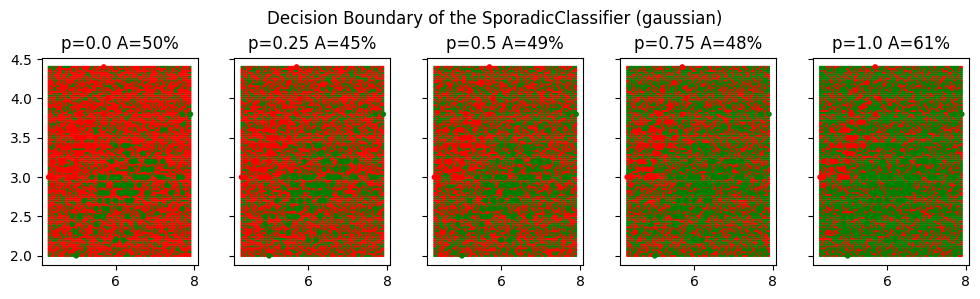

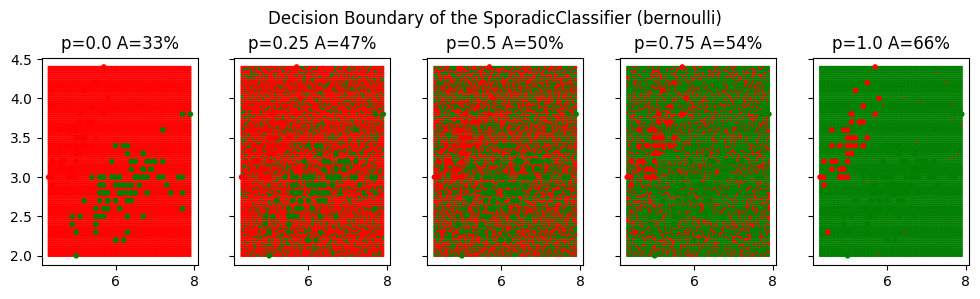

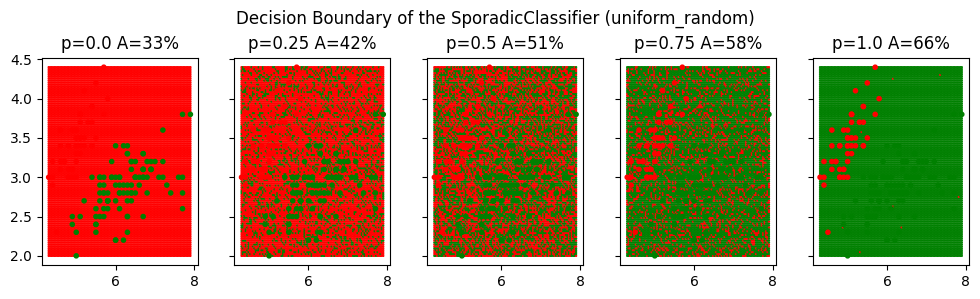

In [22]:
# iterate over the methods.
for rand_type in ['gaussian', 'bernoulli', 'uniform_random']:
    fig, axes = plt.subplots(1, 5, sharey='row')
    fig.suptitle(f'Decision Boundary of the SporadicClassifier ({rand_type})')
    # reduce the width and height if your screen size is smaller!
    fig.set_figwidth(10)
    fig.set_figheight(3)
    fig.tight_layout()
    # iterate over the p-values.
    for p in enumerate(np.arange(0, 1.1, 0.25)):
        # create the instance of the classifier.
        classifier = SporadicClassifier(p = p[1], method = rand_type)
        # the fit() method is rhetoric, so we don't have to fit the model.
        # go for prediction directly.
        yyhat = classifier.predict(xx)
        # compute the accuracy of the classifier
        accuracy = int(100 * np.sum(yyhat == yy) / len(yy))
        # call the visualization helper to plot.
        visualize_decision_boundary(df_x, yy, classifier, axes[p[0]], f"p={p[1]} A={accuracy}%")
        

___The best performance even from a sporadic classifier is 58% at p=.75.  I am ignoring the performance at p=0 and p=1 as it just reflects the class proportion.___